## 用决策树来分类贷款是否优良

[LendingClub](https://www.lendingclub.com/) 是一家贷款公司. 在本次作业中,我们需要手动实现决策树来预测一份贷款是否安全，并对比不同复杂度下决策树的表现

In [22]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn import metrics


## 读取数据

In [175]:
#data = pd.read_csv(os.path.join("data", "loan_sub.csv"), sep=',')
data = pd.read_csv("loan_sub.csv", sep=',')

/Users/colinchen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 打印可用特征

In [176]:
features=list(data.columns)

In [177]:
features.pop(features.index('bad_loans'))

'bad_loans'

In [178]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## 预处理预测目标

预测目标是一列'bad_loans'的数据。其中**1**表示的是不良贷款，**0**表示的是优质贷款。

将预测目标处理成更符合直觉的标签，创建一列 `safe_loans`. 并且: 

* **+1** 表示优质贷款, 
* **-1** 表示不良贷款. 

In [179]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
data['safe_loans'] = data['bad_loans'].apply(lambda x : +1 if x==0 else -1)
data = data.drop('bad_loans', axis=1)

## 打印优质贷款与不良贷款的比例

In [180]:
data['safe_loans'].value_counts(normalize=True)

 1    0.811185
-1    0.188815
Name: safe_loans, dtype: float64

#### 这是一个不平衡数据， 好的贷款远比坏的贷款要多. 

## 选取用于预测的特征

In [181]:
import seaborn as sns

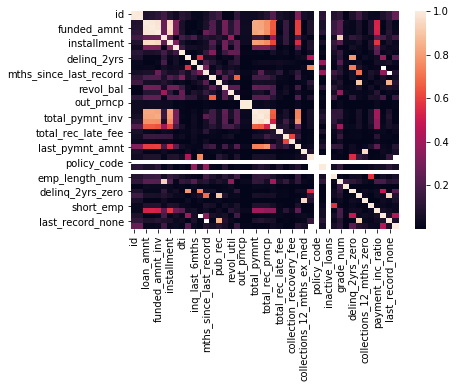

In [182]:
corr=data[features].corr().abs()
sns.heatmap(corr)
plt.show()

In [183]:
#select upper triangle of correlation matrix
upper=corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
#find index of feature columns with corrlation greater than 0.95
to_drop=[column for column in upper.columns if any(upper[column]>0.95)]

In [184]:
to_drop

['member_id',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'collections_12_mths_zero']

In [185]:
#drop marked features
data=data.drop(to_drop,axis=1)

In [186]:
data.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'not_compliant', 'status',
       'inactive_loans', 'emp_length_num', 'grade_num', 'sub_grade_num',
       'delinq_2yrs_zero', 'pub_rec_zero', 'short_emp', 'payment_inc_ratio',
       'final_d', 'last_delinq_none', 'last_record_none',


In [188]:
to_drop_2=['status','title','desc','loan_status','emp_title','id','zip_code','issue_d','pymnt_plan','url','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','mths_since_last_major_derog','final_d']
data=data.drop(to_drop_2,axis=1)

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 44 columns):
loan_amnt                     122607 non-null int64
term                          122607 non-null object
int_rate                      122607 non-null float64
grade                         122607 non-null object
sub_grade                     122607 non-null object
emp_length                    118516 non-null object
home_ownership                122607 non-null object
annual_inc                    122603 non-null float64
is_inc_v                      122607 non-null object
purpose                       122607 non-null object
addr_state                    122607 non-null object
dti                           122607 non-null float64
delinq_2yrs                   122578 non-null float64
inq_last_6mths                122578 non-null float64
mths_since_last_delinq        50500 non-null float64
mths_since_last_record        12531 non-null float64
open_acc                      122578 

In [193]:
data['loan_amnt_range']=data['loan_amnt'].apply(lambda x: '500-5000' if x>5000 
                                                else ('5000-10000' if x>=5000 and x<10000
                                                else('10000-15000' if x>=10000 and x<15000
                                                else('15000-20000' if x>=15000 and x<20000
                                               else('20000-25000' if x>=20000 and x<25000
                                               else('25000-30000' if x>=25000 and x<30000
                                               else '30000-35000'))))))

In [200]:
data=data.drop('loan_amnt',axis=1)

In [202]:
data['int_rate_range']=data['int_rate'].apply(lambda x: '5-8' if x<8 
                                                else ('8-11' if x>=8 and x<11
                                                else('11-14' if x>=11 and x<14
                                                else('14-17' if x>=14 and x<17
                                               else('17-20' if x>=17 and x<20
                                               else('20-23' if x>=20 and x<23
                                               else '23-26'))))))

In [203]:
data['safe_loans'].groupby(data['int_rate_range']).mean()

int_rate_range
11-14    0.678210
14-17    0.562919
17-20    0.409526
20-23    0.287522
23-26    0.226753
5-8      0.873005
8-11     0.778421
Name: safe_loans, dtype: float64

In [204]:
data=data.drop('int_rate',axis=1)

In [206]:
data=data.drop('sub_grade',axis=1)

In [210]:
data['annual_inc_range']=data['annual_inc'].apply(lambda x: '1000-10000' if x<10000 
                                                else ('10000-100000' if x>=10000 and x<100000
                                                else('100000-1000000' if x>=100000 and x<1000000
                                                else('1000000-10000000'))))

In [211]:
data['safe_loans'].groupby(data['annual_inc_range']).mean()

annual_inc_range
1000-10000          0.594406
10000-100000        0.599607
100000-1000000      0.734615
1000000-10000000    1.000000
Name: safe_loans, dtype: float64

In [212]:
data=data.drop('annual_inc',axis=1)

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 38 columns):
term                          122607 non-null object
grade                         122607 non-null object
emp_length                    118516 non-null object
home_ownership                122607 non-null object
is_inc_v                      122607 non-null object
purpose                       122607 non-null object
addr_state                    122607 non-null object
delinq_2yrs                   122578 non-null float64
pub_rec                       122578 non-null float64
revol_bal                     122607 non-null int64
revol_util                    122607 non-null float64
total_acc                     122578 non-null float64
initial_list_status           122607 non-null object
out_prncp                     122607 non-null float64
total_pymnt                   122607 non-null float64
total_rec_int                 122607 non-null float64
total_rec_late_fee            12260

In [242]:
cols = ['grade','term','home_ownership', 'emp_length','is_inc_v','purpose','addr_state','loan_amnt_range','int_rate_range','annual_inc_range']
target = 'safe_loans'

data = data[cols + [target]]
data.head()

,grade,term,home_ownership,emp_length,is_inc_v,purpose,addr_state,loan_amnt_range,int_rate_range,annual_inc_range,safe_loans
0,B,36 months,RENT,10+ years,Verified,credit_card,AZ,5000-10000,8-11,10000-100000,1
1,C,60 months,RENT,< 1 year,Source Verified,car,GA,30000-35000,14-17,10000-100000,-1
2,C,36 months,RENT,10+ years,Not Verified,small_business,IL,30000-35000,14-17,10000-100000,1
3,C,36 months,RENT,10+ years,Source Verified,other,CA,500-5000,11-14,10000-100000,1
4,A,36 months,RENT,3 years,Source Verified,wedding,AZ,5000-10000,5-8,10000-100000,1


## 创建更为平衡的数据集  

* 对占多数的标签进行下采样     

In [243]:
data['safe_loans'].value_counts()

 1    99457
-1    23150
Name: safe_loans, dtype: int64

In [244]:
# use the percentage of bad and good loans to undersample the safe loans.
bad_ones = data[data[target] == -1]
safe_ones = data[data[target] == 1]
percentage = len(bad_ones)/float(len(safe_ones))

risky_loans = bad_ones
safe_loans = safe_ones.sample(frac=percentage, random_state=33)

# combine two kinds of loans
data_set = pd.concat([risky_loans, safe_loans], axis=0)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [245]:
data_set[target].value_counts(normalize=True)

-1    0.5
 1    0.5
Name: safe_loans, dtype: float64

## Preprocessing your features

In [246]:
def dummies(data, columns=['pclass','name_title','embarked', 'sex']):
    for col in columns:
        data[col] = data[col].apply(lambda x: str(x))
        new_cols = [col + '_' + i for i in data[col].unique()]
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)[new_cols]], axis=1)
        del data[col]
    return data

In [247]:
#grade, home_ownership, target
cols = ['grade','term','home_ownership', 'emp_length','is_inc_v','purpose','addr_state','loan_amnt_range','int_rate_range','annual_inc_range']
data_set = dummies(data_set, columns=cols)
data_set.head()

,safe_loans,grade_C,grade_F,grade_B,grade_D,grade_A,grade_E,grade_G,term_ 60 months,term_ 36 months,...,int_rate_range_20-23,int_rate_range_11-14,int_rate_range_8-11,int_rate_range_17-20,int_rate_range_5-8,int_rate_range_23-26,annual_inc_range_10000-100000,annual_inc_range_100000-1000000,annual_inc_range_1000-10000,annual_inc_range_1000000-10000000
1,-1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6,-1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
7,-1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
10,-1,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
12,-1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


## 将数据分成训练集和测试集

In [248]:
train_data, test_data = train_test_split(data_set, test_size=0.2, random_state=33)
trainX, trainY = train_data[train_data.columns[1:]], pd.DataFrame(train_data[target])
testX, testY = test_data[test_data.columns[1:]], pd.DataFrame(test_data[target])

## 建自己的决策树!  
 
1 实现根据error来选择最佳划分特征的函数best_split()  
2 实现根据entropy来选择最佳特征的函数best_split_entropy()  
3 实现树节点的类TreeNode  
4 实现模型的类MyDecisionTree  

#### 实现根据error来选择最佳划分特征的函数best_split()  
约定树的左边对应target == 0， 树的右边对应target == 1

In [249]:
def count_errors(labels_in_node):
    if len(labels_in_node) == 0:
        return 0
    
    positive_ones = labels_in_node.apply(lambda x: x==1).sum()
    negative_ones = labels_in_node.apply(lambda x: x==-1).sum()
    
    return min(positive_ones, negative_ones)


def best_split(data, features, target):
    # return the best feature
    best_feature = None
    best_error = 2.0 
    num_data_points = float(len(data))  

    for feature in features:
        
        # 左分支对应当前特征为0的数据点
        left_split = data[data[feature] == 0]
        
        # 右分支对应当前特征为1的数据点
        right_split = data[data[feature] == 1] 
        
        # 计算左边分支里犯了多少错
        left_misses = count_errors(left_split[target])            

        # 计算右边分支里犯了多少错
        right_misses = count_errors(right_split[target])
            
        # 计算当前划分之后的分类犯错率
        error = (left_misses + right_misses) * 1.0 / num_data_points

        # 更新应选特征和错误率，注意错误越低说明该特征越好
        if error < best_error:
            best_error = error
            best_feature = feature
    return best_feature

#### 实现根据entropy来选择最佳特征的函数best_split_entropy()  


In [250]:
def entropy(labels_in_node):
    # 二分类问题: 0 or 1
    n = len(labels_in_node)
    s1 = (labels_in_node==1).sum()
    if s1 == 0 or s1 == n:
        return 0
    
    p1 = float(s1) / n
    p0 = 1 - p1
    return -p0 * np.log2(p0) - p1 * np.log2(p1)


def best_split_entropy(data, features, target):
    
    best_feature = None
    best_info_gain = float('-inf') 
    num_data_points = float(len(data))
    # 计算划分之前数据集的整体熵值
    entropy_original = entropy(data[target])

    for feature in features:
        
        # 左分支对应当前特征为0的数据点
        left_split = data[data[feature] == 0]
        
        # 右分支对应当前特征为1的数据点
        right_split = data[data[feature] == 1] 
        
        # 计算左边分支的熵值
        left_entropy = entropy(left_split[target])            

        # 计算右边分支的熵值
        right_entropy = entropy(right_split[target])
            
        # 计算左边分支与右分支熵值的加权和（数据集划分后的熵值）
        entropy_split = len(left_split) / num_data_points * left_entropy + len(right_split) / num_data_points * right_entropy
        
        # 计算划分前与划分后的熵值差得到信息增益
        info_gain = entropy_original - entropy_split

        # 更新最佳特征和对应的信息增益的值
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature
    return best_feature
    

#### 实现树节点的类TreeNode，每个树节点应该包含如下信息:  

   3.1 is_leaf: True/False  表示当前节点是否为叶子节点  
   
   3.2 prediction: 当前节点做全民公投的预测结果
   
   3.3 left: 左子树  
   
   3.4 right: 右子树 
   
   3.5 split_feature: 当前节点用来划分数据时所采用的特征

In [251]:
class TreeNode:
    def __init__(self, is_leaf, prediction, split_feature):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_feature = split_feature
        self.left = None
        self.right = None

#### 实现模型的类MyDecisionTree， 实现如下主要函数  
  
  
   4.1 fit(): 模型在训练集上的学习  
   
   4.2 predict(): 模型在数据集上的预测
   
   4.3 score(): 模型在测试集上的得分   
   
   
   
   
   为了实现4.1 - 4.3的方法， 需要实现如下辅助函数  
   4.4 create_tree(): 创建一棵树  
   
   4.5 create_leaf(): 创建叶子节点  
   
   4.6 predict_single_data(): 模型预测单个数据  
   
   4.7 count_leaves(): 统计模型的叶子数

In [263]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
class MyDecisionTree(BaseEstimator):
    
    def __init__(self, max_depth, min_error):
        self.max_depth = max_depth
        self.min_error = min_error
    
    def fit(self, X, Y, data_weights = None):
        
        data_set = pd.concat([X, Y], axis=1)
        features = X.columns
        target = Y.columns[0]
        self.root_node = self.create_tree(data_set, features, 
                               target, current_depth = 0, max_depth = self.max_depth, min_error=self.min_error)
        
        
    def predict(self, X):
        prediction = X.apply(lambda row: self.predict_single_data(self.root_node, row), axis=1)
        return prediction
        
        
    def score(self, testX, testY):
        target = testY.columns[0]
        result = self.predict(testX)
        return accuracy_score(testY[target], result)
    
    
    def create_tree(self, data, features, target, current_depth = 0, max_depth = 10, min_error=0):
        """
        探索三种不同的终止划分数据集的条件  
  
        termination 1, 当错误率降到min_error以下, 终止划分并返回叶子节点  
        termination 2, 当特征都用完了, 终止划分并返回叶子节点  
        termination 3, 当树的深度等于最大max_depth时, 终止划分并返回叶子节点
        """
        
    
        # 拷贝以下可用特征
        remaining_features = features[:]

        target_values = data[target]

        # termination 1  bonus task
        if count_errors(target_values) <= min_error:
            print("Termination 1 reached.")     
            return self.create_leaf(target_values)

        # termination 2
        if len(remaining_features) == 0:
            print("Termination 2 reached.")    
            return self.create_leaf(target_values)    

        # termination 3
        if current_depth >= max_depth: 
            print("Termination 3 reached.")
            return self.create_leaf(target_values)



        # 选出最佳当前划分特征
        #split_feature = best_split(data, features, target)   #根据正确率划分 bonus task
        split_feature = best_split_entropy(data, features, target)  # 根据信息增益来划分

        # 选出最佳特征后，该特征为0的数据分到左边，该特征为1的数据分到右边
        left_split = data[data[split_feature] == 0]
        right_split = data[data[split_feature] == 1]

        # 剔除已经用过的特征
        remaining_features = remaining_features.drop(split_feature)
        print("Split on feature %s. (%s, %s)" % (split_feature, str(len(left_split)), str(len(right_split))))

        # 如果当前数据全部划分到了一边，直接创建叶子节点返回即可
        if len(left_split) == len(data):
            print("Perfect split!")
            return self.create_leaf(left_split[target])
        if len(right_split) == len(data):
            print("Perfect split!")
            return self.create_leaf(right_split[target])

        # 递归上面的步骤
        left_tree = self.create_tree(left_split, remaining_features, target, current_depth + 1, max_depth, min_error)        
        right_tree = self.create_tree(right_split,remaining_features,target, current_depth + 1, max_depth, min_error)


        #生成当前的树节点
        result_node = TreeNode(False, None, split_feature)
        result_node.left = left_tree
        result_node.right = right_tree
        return result_node    
    
    
    
    def create_leaf(self, target_values):
        # 用于创建叶子的函数

        # 初始化一个树节点
        leaf = TreeNode(True, None, None)

        # 统计当前数据集里标签为+1和-1的个数，较大的那个即为当前节点的预测结果
        num_positive_ones = len(target_values[target_values == +1])
        num_negative_ones = len(target_values[target_values == -1])

        if num_positive_ones > num_negative_ones:
            leaf.prediction = 1
        else:
            leaf.prediction = -1

        # 返回叶子        
        return leaf 
    
    
    
    def predict_single_data(self, tree, x, annotate = False):   
        # 如果已经是叶子节点直接返回叶子节点的预测结果
        if tree.is_leaf:
            if annotate: 
                print("leaf node, predicting %s" % tree.prediction)
            return tree.prediction 
        else:
            # 查询当前节点用来划分数据集的特征
            split_feature_value = x[tree.split_feature]

            if annotate: 
                print("Split on %s = %s" % (tree.split_feature, split_feature_value))
            if split_feature_value == 0:
                #如果数据在该特征上的值为0，交给左子树来预测
                return self.predict_single_data(tree.left, x, annotate)
            else:
                #如果数据在该特征上的值为0，交给右子树来预测
                return self.predict_single_data(tree.right, x, annotate)    
    
    def count_leaves(self):
        return self.count_leaves_helper(self.root_node)
    
    def count_leaves_helper(self, tree):
        if tree.is_leaf:
            return 1
        return self.count_leaves_helper(tree.left) + self.count_leaves_helper(tree.right)
    


In [264]:
#my_decesion_tree = create_tree(train_data, features, target, current_depth = 0, max_depth = 10)
m = MyDecisionTree(max_depth = 10, min_error = 1e-15)

In [265]:
m.fit(trainX, trainY)

Split on feature grade_A. (31776, 5264)
Split on feature grade_B. (21587, 10189)
Split on feature grade_C. (12308, 9279)
Split on feature int_rate_range_14-17. (9946, 2362)
Split on feature int_rate_range_17-20. (4350, 5596)
Split on feature grade_D. (3988, 362)
Split on feature annual_inc_range_10000-100000. (766, 3222)
Split on feature emp_length_5 years. (713, 53)
Split on feature emp_length_nan. (705, 8)
Split on feature emp_length_4 years. (650, 55)
Termination 3 reached.
Termination 3 reached.
Termination 1 reached.
Split on feature purpose_other. (51, 2)
Split on feature addr_state_NJ. (49, 2)
Termination 3 reached.
Termination 1 reached.
Termination 1 reached.
Split on feature term_ 60 months. (880, 2342)
Split on feature purpose_small_business. (819, 61)
Split on feature home_ownership_MORTGAGE. (592, 227)
Termination 3 reached.
Termination 3 reached.
Split on feature int_rate_range_23-26. (46, 15)
Termination 3 reached.
Termination 3 reached.
Split on feature home_ownership_M

Split on feature loan_amnt_range_30000-35000. (12, 2)
Termination 3 reached.
Termination 1 reached.
Split on feature addr_state_GA. (27, 1)
Split on feature addr_state_NY. (26, 1)
Split on feature addr_state_KS. (25, 1)
Termination 1 reached.
Termination 1 reached.
Termination 1 reached.
Termination 1 reached.
Split on feature home_ownership_RENT. (868, 299)
Split on feature int_rate_range_17-20. (806, 62)
Split on feature emp_length_5 years. (735, 71)
Split on feature emp_length_8 years. (695, 40)
Split on feature purpose_other. (646, 49)
Split on feature addr_state_KS. (641, 5)
Termination 3 reached.
Termination 3 reached.
Split on feature addr_state_MI. (47, 2)
Termination 3 reached.
Termination 1 reached.
Split on feature is_inc_v_Not Verified. (36, 4)
Split on feature purpose_small_business. (33, 3)
Termination 3 reached.
Termination 1 reached.
Termination 1 reached.
Split on feature is_inc_v_Source Verified. (50, 21)
Split on feature addr_state_IL. (46, 4)
Split on feature term_ 

Split on feature int_rate_range_14-17. (799, 14)
Split on feature addr_state_MT. (793, 6)
Split on feature addr_state_UT. (787, 6)
Split on feature addr_state_CO. (771, 16)
Termination 3 reached.
Termination 3 reached.
Termination 1 reached.
Termination 1 reached.
Split on feature addr_state_TX. (13, 1)
Termination 1 reached.
Termination 1 reached.
Split on feature is_inc_v_Not Verified. (23, 19)
Split on feature addr_state_GA. (21, 2)
Split on feature home_ownership_OWN. (20, 1)
Split on feature emp_length_5 years. (19, 1)
Termination 3 reached.
Termination 1 reached.
Termination 1 reached.
Termination 1 reached.
Split on feature addr_state_PA. (18, 1)
Termination 1 reached.
Termination 1 reached.
Split on feature emp_length_9 years. (39, 1)
Split on feature loan_amnt_range_5000-10000. (38, 1)
Split on feature emp_length_3 years. (32, 6)
Split on feature addr_state_CA. (27, 5)
Termination 1 reached.
Split on feature home_ownership_RENT. (3, 2)
Termination 3 reached.
Termination 1 reac

In [266]:
m.score(testX, testY)

0.6227861771058315

### 决策树复杂度的探讨

In [257]:
m.count_leaves()

359

#### 探索不同树深度对决策树的影响  

1 max_depth = 3  
2 max_depth = 7  
3 max_depth = 15


In [258]:
model_1 = MyDecisionTree(max_depth = 3, min_error = 1e-15)
model_2 = MyDecisionTree(max_depth = 7, min_error = 1e-15)
model_3 = MyDecisionTree(max_depth = 15, min_error = 1e-15)


In [259]:
model_1.fit(trainX, trainY)
model_2.fit(trainX, trainY)
model_3.fit(trainX, trainY)

Split on feature grade_A. (31776, 5264)
Split on feature grade_B. (21587, 10189)
Split on feature grade_C. (12308, 9279)
Termination 3 reached.
Termination 3 reached.
Split on feature annual_inc_range_10000-100000. (1417, 8772)
Termination 3 reached.
Termination 3 reached.
Split on feature annual_inc_range_100000-1000000. (4297, 967)
Split on feature emp_length_nan. (4085, 212)
Termination 3 reached.
Termination 3 reached.
Split on feature purpose_home_improvement. (826, 141)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_A. (31776, 5264)
Split on feature grade_B. (21587, 10189)
Split on feature grade_C. (12308, 9279)
Split on feature int_rate_range_14-17. (9946, 2362)
Split on feature int_rate_range_17-20. (4350, 5596)
Split on feature grade_D. (3988, 362)
Split on feature annual_inc_range_10000-100000. (766, 3222)
Termination 3 reached.
Termination 3 reached.
Split on feature purpose_car. (356, 6)
Termination 3 reached.
Termination 3 reached.
Split on feature an

Split on feature addr_state_MD. (618, 32)
Split on feature purpose_small_business. (577, 41)
Split on feature int_rate_range_23-26. (373, 204)
Split on feature loan_amnt_range_30000-35000. (369, 4)
Split on feature emp_length_8 years. (355, 14)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (4, 0)
Perfect split!
Split on feature emp_length_2 years. (195, 9)
Split on feature purpose_medical. (188, 7)
Termination 3 reached.
Termination 3 reached.
Split on feature home_ownership_RENT. (6, 3)
Termination 3 reached.
Termination 3 reached.
Split on feature emp_length_9 years. (40, 1)
Split on feature addr_state_IL. (39, 1)
Split on feature addr_state_DC. (38, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature emp_length_7 years. (29, 3)
Split on feature purpose_house. (27, 2)
Split on feature is_inc_v_Source Verified. (20, 7)
Split on feature emp_length_3 ye

Perfect split!
Split on feature grade_F. (2, 2)
Split on feature grade_E. (0, 2)
Perfect split!
Split on feature purpose_debt_consolidation. (1, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (0, 2)
Perfect split!
Split on feature grade_F. (7, 4)
Split on feature grade_E. (2, 5)
Split on feature grade_G. (0, 2)
Perfect split!
Split on feature grade_G. (5, 0)
Perfect split!
Split on feature grade_E. (4, 0)
Perfect split!
Split on feature int_rate_range_23-26. (690, 401)
Split on feature emp_length_7 years. (636, 54)
Split on feature addr_state_TN. (626, 10)
Split on feature addr_state_MN. (618, 8)
Split on feature addr_state_NY. (593, 25)
Split on feature addr_state_UT. (586, 7)
Termination 3 reached.
Termination 3 reached.
Split on feature emp_length_10+ years. (16, 9)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (7, 1)
Split on feature grade_E. (0, 7)
Perfect split!
Split on feature grade_E. (1, 0)
Perfect split!
Split on feature 

Split on feature addr_state_NY. (11, 2)
Split on feature grade_F. (11, 0)
Perfect split!
Split on feature emp_length_3 years. (1, 1)
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature is_inc_v_Source Verified. (2, 1)
Split on feature grade_F. (2, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature purpose_medical. (10, 1)
Split on feature grade_F. (10, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature is_inc_v_Not Verified. (14, 6)
Split on feature grade_F. (13, 1)
Split on feature grade_D. (2, 11)
Split on feature grade_E. (0, 2)
Perfect split!
Split on feature grade_E. (11, 0)
Perfect split!
Split on feature grade_D. (1, 0)
Perfect split!
Split on feature emp_length_6 years. (5, 1)
Split on feature grade_D. (2, 3)
Split on feature grade_F. (2, 0)
Perfect split!
Split on feature emp_length_10+ years. (1, 2)
Split on feature grade_F. (1, 0)
Perfect split!
Split 

Split on feature addr_state_OH. (147, 4)
Split on feature loan_amnt_range_5000-10000. (139, 8)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_E. (4, 0)
Perfect split!
Split on feature grade_D. (0, 4)
Perfect split!
Split on feature grade_D. (1, 3)
Split on feature grade_E. (0, 1)
Perfect split!
Split on feature grade_E. (3, 0)
Perfect split!
Split on feature grade_D. (0, 5)
Perfect split!
Split on feature grade_D. (0, 5)
Perfect split!
Split on feature emp_length_3 years. (84, 13)
Split on feature emp_length_9 years. (81, 3)
Split on feature emp_length_7 years. (78, 3)
Split on feature emp_length_4 years. (71, 7)
Split on feature addr_state_WA. (70, 1)
Split on feature addr_state_NC. (69, 1)
Split on feature addr_state_KY. (68, 1)
Split on feature home_ownership_OWN. (66, 2)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_D. (0, 1)
Perfect split!
Split on feature grade_D. (0, 1)
Perfect split!
Split on feature grade_D. (0, 1)
Perfect split!
Sp

Split on feature grade_D. (1, 1)
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature home_ownership_RENT. (1, 1)
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature annual_inc_range_100000-1000000. (8112, 1167)
Split on feature int_rate_range_11-14. (5826, 2286)
Split on feature int_rate_range_17-20. (5193, 633)
Split on feature addr_state_NV. (5105, 88)
Split on feature emp_length_nan. (4853, 252)
Split on feature addr_state_WY. (4840, 13)
Split on feature addr_state_TN. (4790, 50)
Split on feature home_ownership_RENT. (2474, 2316)
Split on feature addr_state_WA. (2416, 58)
Split on feature is_inc_v_Verified. (1266, 1150)
Split on feature purpose_home_improvement. (1171, 95)
Split on feature addr_state_UT. (1156, 15)
Termination 3 reached.
Termination 3 reached.
Split on

Split on feature emp_length_3 years. (1517, 175)
Split on feature addr_state_OR. (1496, 21)
Split on feature home_ownership_MORTGAGE. (981, 515)
Split on feature addr_state_TN. (978, 3)
Split on feature addr_state_VA. (936, 42)
Split on feature emp_length_2 years. (792, 144)
Termination 3 reached.
Termination 3 reached.
Split on feature emp_length_5 years. (40, 2)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (3, 0)
Perfect split!
Split on feature purpose_home_improvement. (450, 65)
Split on feature is_inc_v_Verified. (324, 126)
Split on feature addr_state_MN. (317, 7)
Termination 3 reached.
Termination 3 reached.
Split on feature loan_amnt_range_5000-10000. (121, 5)
Termination 3 reached.
Termination 3 reached.
Split on feature emp_length_8 years. (62, 3)
Split on feature addr_state_FL. (59, 3)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (3, 0)
Perfect split!
Split on feature purpose_debt_consolidation. (12, 9)
Split on feature gra

Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature home_ownership_RENT. (868, 299)
Split on feature int_rate_range_17-20. (806, 62)
Split on feature emp_length_5 years. (735, 71)
Split on feature emp_length_8 years. (695, 40)
Split on feature purpose_other. (646, 49)
Split on feature addr_state_KS. (641, 5)
Split on feature emp_length_3 years. (586, 55)
Split on feature purpose_debt_consolidation. (251, 335)
Split on feature emp_length_< 1 year. (234, 17)
Split on feature purpose_vacation. (227, 7)
Split on feature emp_length_nan. (221, 6)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (7, 0)
Perfect split!
Split on feature is_inc_v_Verified. (12, 5)
Split on feature loan_amnt_range_30000-35000. (10, 2)
Termination 3 reached.
Termination 3 reached.
Split on feature purpose_small_business. (4, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature addr_state_NH. (333, 2)
Split on feature ad

Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (4, 0)
Perfect split!
Split on feature addr_state_WA. (77, 8)
Split on feature purpose_credit_card. (67, 10)
Split on feature term_ 60 months. (58, 9)
Split on feature is_inc_v_Verified. (26, 32)
Split on feature emp_length_10+ years. (23, 3)
Split on feature emp_length_4 years. (21, 2)
Split on feature emp_length_5 years. (20, 1)
Split on feature purpose_car. (19, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (2, 0)
Perfect split!
Split on feature grade_F. (3, 0)
Perfect split!
Split on feature purpose_major_purchase. (31, 1)
Split on feature purpose_wedding. (30, 1)
Split on feature addr_state_FL. (29, 1)
Split on feature addr_state_MN. (28, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_F. (1, 0)
Perfect split!
Split on feature grade_F. (1, 0)
Perfect split!
Spli

Perfect split!
Split on feature home_ownership_RENT. (1, 1)
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature is_inc_v_Source Verified. (3, 1)
Split on feature grade_C. (3, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature home_ownership_MORTGAGE. (19, 22)
Split on feature grade_C. (19, 0)
Perfect split!
Split on feature addr_state_PA. (21, 1)
Split on feature addr_state_LA. (20, 1)
Split on feature loan_amnt_range_5000-10000. (19, 1)
Split on feature addr_state_TX. (15, 4)
Split on feature grade_C. (15, 0)
Perfect split!
Split on feature purpose_debt_consolidation. (2, 2)
Split on feature grade_C. (2, 0)
Perfect split!
Split on feature grade_C. (2, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature emp_length_7 years. (31, 2)
Split on feature purpose_small_business

Split on feature home_ownership_RENT. (2, 2)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (7, 0)
Perfect split!
Split on feature is_inc_v_Not Verified. (49, 50)
Split on feature purpose_credit_card. (41, 8)
Split on feature addr_state_FL. (37, 4)
Split on feature is_inc_v_Source Verified. (22, 15)
Split on feature addr_state_OR. (21, 1)
Split on feature addr_state_MD. (20, 1)
Split on feature addr_state_CT. (19, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature addr_state_IL. (13, 2)
Split on feature addr_state_NC. (12, 1)
Split on feature addr_state_CA. (5, 7)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (2, 0)
Perfect split!
Split on feature is_inc_v_Source Verified. (3, 1)
Split

Split on feature grade_C. (1, 0)
Perfect split!
Split on feature is_inc_v_Source Verified. (1, 1)
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (2, 0)
Perfect split!
Split on feature is_inc_v_Source Verified. (3, 3)
Split on feature addr_state_VA. (2, 1)
Split on feature grade_C. (2, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (3, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature annual_inc_range_100000-1000000. (4297, 967)
Split on feature emp_length_nan. (4085, 212)
Split on feature int_rate_range_8-11. (3023, 1062)
Split on feature purpose_small_business. (2914, 109)
Split on feature addr_state_DC. (2897, 17)
Split on feature purpose_moving. (2859, 38)
Split on feature purpose_vacation. (2825, 34)
Split on feature addr_state_TX. (2645, 180)
Split on feature purpose_other. (2413, 23

Split on feature emp_length_6 years. (7, 1)
Split on feature grade_C. (7, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (1, 0)
Perfect split!
Split on feature grade_C. (8, 0)
Perfect split!
Split on feature home_ownership_RENT. (605, 457)
Split on feature addr_state_LA. (590, 15)
Split on feature emp_length_2 years. (541, 49)
Split on feature addr_state_SD. (539, 2)
Split on feature addr_state_AR. (535, 4)
Split on feature addr_state_MI. (521, 14)
Split on feature purpose_credit_card. (419, 102)
Split on feature addr_state_KS. (415, 4)
Split on feature addr_state_FL. (382, 33)
Split on feature home_ownership_MORTGAGE. (42, 340)
Split on feature addr_state_MD. (41, 1)
Termination 3 reached.
Termination 3 reached.
Split on feature emp_length_4 years. (322, 18)
Termination 3 reached.
Termination 3 reached.
Split on feature purpose_debt_consolidation. (16, 17)
Split on feature home_ownership_OTHER

Split on feature emp_length_4 years. (741, 55)
Split on feature addr_state_NV. (733, 8)
Split on feature addr_state_CO. (722, 11)
Split on feature addr_state_MT. (721, 1)
Split on feature addr_state_WY. (720, 1)
Split on feature addr_state_VA. (682, 38)
Split on feature int_rate_range_8-11. (483, 199)
Split on feature emp_length_9 years. (467, 16)
Split on feature emp_length_< 1 year. (420, 47)
Split on feature addr_state_NY. (376, 44)
Split on feature purpose_wedding. (373, 3)
Termination 3 reached.
Termination 3 reached.
Split on feature home_ownership_OWN. (41, 3)
Termination 3 reached.
Termination 3 reached.
Split on feature addr_state_CA. (39, 8)
Split on feature addr_state_NY. (32, 7)
Termination 3 reached.
Termination 3 reached.
Split on feature is_inc_v_Verified. (4, 4)
Termination 3 reached.
Termination 3 reached.
Split on feature grade_C. (16, 0)
Perfect split!
Split on feature addr_state_IL. (192, 7)
Split on feature addr_state_FL. (176, 16)
Split on feature addr_state_WA. (

In [260]:
print("model_1 training accuracy :", model_1.score(trainX, trainY))
print("model_2 training accuracy :", model_2.score(trainX, trainY))
print("model_3 training accuracy :", model_3.score(trainX, trainY))

model_1 training accuracy : 0.6147948164146868
model_2 training accuracy : 0.6368250539956803
model_3 training accuracy : 0.6791846652267819


In [261]:
print("model_1 testing accuracy :", model_1.score(testX, testY))
print("model_2 testing accuracy :", model_2.score(testX, testY))
print("model_3 testing accuracy :", model_3.score(testX, testY))

model_1 testing accuracy : 0.6152267818574514
model_2 testing accuracy : 0.6259179265658747
model_3 testing accuracy : 0.6183585313174946


In [262]:
print("model_1 complexity is: ", model_1.count_leaves())
print("model_2 complexity is: ", model_2.count_leaves())
print("model_3 complexity is: ", model_3.count_leaves())

model_1 complexity is:  8
model_2 complexity is:  100
model_3 complexity is:  1381
